In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [6]:
folder_path = '../All CSVs'
# update_column_names_in_csv(folder_path)

In [7]:

def assign_color(rate):
    """Assigns a color based on the normalized incidence rate, handling NaN values."""
    # Check if rate is NaN
    if pd.isna(rate):
        # Return a default color, e.g., gray
        return '#808080'  # Gray color in hex
    else:
        red = int(rate * 255)
        green = 255 - red
        blue = 0  # Blue component remains 0 throughout
        # Convert RGB to hex
        return '#{:02x}{:02x}{:02x}'.format(red, green, blue)


In [2]:

from pathlib import Path

def process_files_in_folder_pathlib(folder_path):
    files_list = []  # Creates a list of all files in a given folder as strings
    folder = Path(folder_path)
    for file in folder.glob('*.csv'):  # Changed pattern to '*.csv' to filter files
        if file.is_file():
            files_list.append(str(file))  # Convert Path object to string
        else:
            print(f"{file} is a directory, skipping.\n")
    return files_list  # Return the list of file paths as strings




In [8]:
def filter_csv_by_date_and_columns(csv_file_path, date, columns_to_keep):
    """
    Filter a CSV file to only include rows for a specific date and a subset of columns.

    Parameters:
    - csv_file_path: Path to the CSV file.
    - date: The specific date to filter for (as a string).
    - columns_to_keep: List of columns to keep in the filtered DataFrame.

    Returns:
    - A filtered DataFrame with correctly formatted state_fips codes.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Convert the 'date' column to datetime to ensure proper comparison
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter the DataFrame for the given date
    filtered_df = df[df['date'] == pd.Timestamp(date)]
    
    # Reduce the DataFrame to only include the specified columns
    filtered_df = filtered_df[columns_to_keep]
    filtered_df['state_fips'] = pd.to_numeric(filtered_df['state_fips'], errors='coerce')

    # Drop rows with NaN values in 'state_fips' if any remain
    filtered_df = filtered_df.dropna(subset=['state_fips'])

    # Now, safely convert to int (since we've ensured all are float/numeric and no NaN values exist)
    filtered_df['state_fips'] = filtered_df['state_fips'].astype(int)

    if 'state_fips' in filtered_df.columns:
            filtered_df['state_fips'] = filtered_df['state_fips'].apply(lambda x: str(x).zfill(2))

    # Verify changes
    print(filtered_df.head(1))


    return filtered_df


In [9]:
def merge_shapefile_with_data(us_counties, filtered_df, output_file_path):
    # Ensure the columns used for merging are in the correct data type
    filtered_df['state_fips'] = filtered_df['state_fips'].astype(str)

    # Before merging, ensure that 'color' column exists in filtered_df with default grey for missing values
    if 'color' not in filtered_df.columns or filtered_df['color'].isnull().all():
        filtered_df['color'] = '#808080'  # Default grey color in hex
    else:
        # Fill missing color values with grey
        filtered_df['color'].fillna('#808080', inplace=True)
    
    # Merge the filtered DataFrame with the GeoDataFrame
    merged_gdf = us_counties.merge(filtered_df, left_on=['STATEFP', 'NAMELSAD'], right_on=['state_fips', 'subregion2_name'], how='left')
    
    # After merging, ensure that any rows in merged_gdf without a 'color' value are set to grey
    if 'color' not in merged_gdf.columns or merged_gdf['color'].isnull().all():
        merged_gdf['color'] = '#808080'  # Default grey color in hex
    else:
        merged_gdf['color'].fillna('#808080', inplace=True)
    
    # Convert 'date' column to string to ensure compatibility with all file formats
    if 'date' in merged_gdf.columns:
        merged_gdf['date'] = merged_gdf['date'].astype(str)

    # Save the merged GeoDataFrame for future use
    merged_gdf.to_file(output_file_path)

    return merged_gdf


In [10]:
import geopandas as gpd
shp_file_path = 'tl_2023_us_county.shp'
shape_df = gpd.read_file(shp_file_path)


In [11]:
def plot_counties_from_merged_gdf(merged_gdf, title, output_png_path):
    # Load the merged shapefile into a GeoDataFrame
    
    # Define the continental US bounds
    continental_us_bounds = {
        "minx": -130,
        "miny": 24,
        "maxx": -66,
        "maxy": 50
    }
    
    # Create a figure and axis with specified figsize and resolution (DPI)
    fig, ax = plt.subplots(figsize=(15, 8), dpi=300)
    
    # Set the bounds for the continental US
    ax.set_xlim(continental_us_bounds["minx"], continental_us_bounds["maxx"])
    ax.set_ylim(continental_us_bounds["miny"], continental_us_bounds["maxy"])
    
    # Plot all counties in the dataset with a neutral color to provide a base map
    merged_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.4)
    
    # Overlay the counties with specified colors where available
    merged_gdf['color'] = merged_gdf['color'].apply(lambda x: '#{:02x}{:02x}{:02x}'.format(*x) if isinstance(x, tuple) else x)
    merged_gdf.dropna(subset=['color']).plot(ax=ax, color=merged_gdf['color'], edgecolor='black', linewidth=0.4)
    
    # Adjust plot parameters
    ax.set_title(title)
    ax.set_axis_off()
    
    # Save the figure to a PNG file with the specified path and high resolution
    plt.savefig(output_png_path, dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()

In [13]:
shp_file_path = 'tl_2023_us_county.shp'
csv_file_path = 'Modified Data/aggregated_monthly_stats.csv'
date = '2021-08-31'  # Use the correct date format as in your CSV
title = 'COVID-19 Incidence Rates by County for August 31, 2021'
colorized_shp_file_path = 'colorized_tl_2023_us_county.shp'
columns_to_keep = ['subregion1_name', 'subregion2_name', 'state_fips', 'color']

output_png_path = 'Test_img.png'

  subregion1_name  subregion2_name state_fips    color
0         Indiana  Hamilton County         18  #00ff00


C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_1312\388494503.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['color'].fillna('#808080', inplace=True)
C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_1312\388494503.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

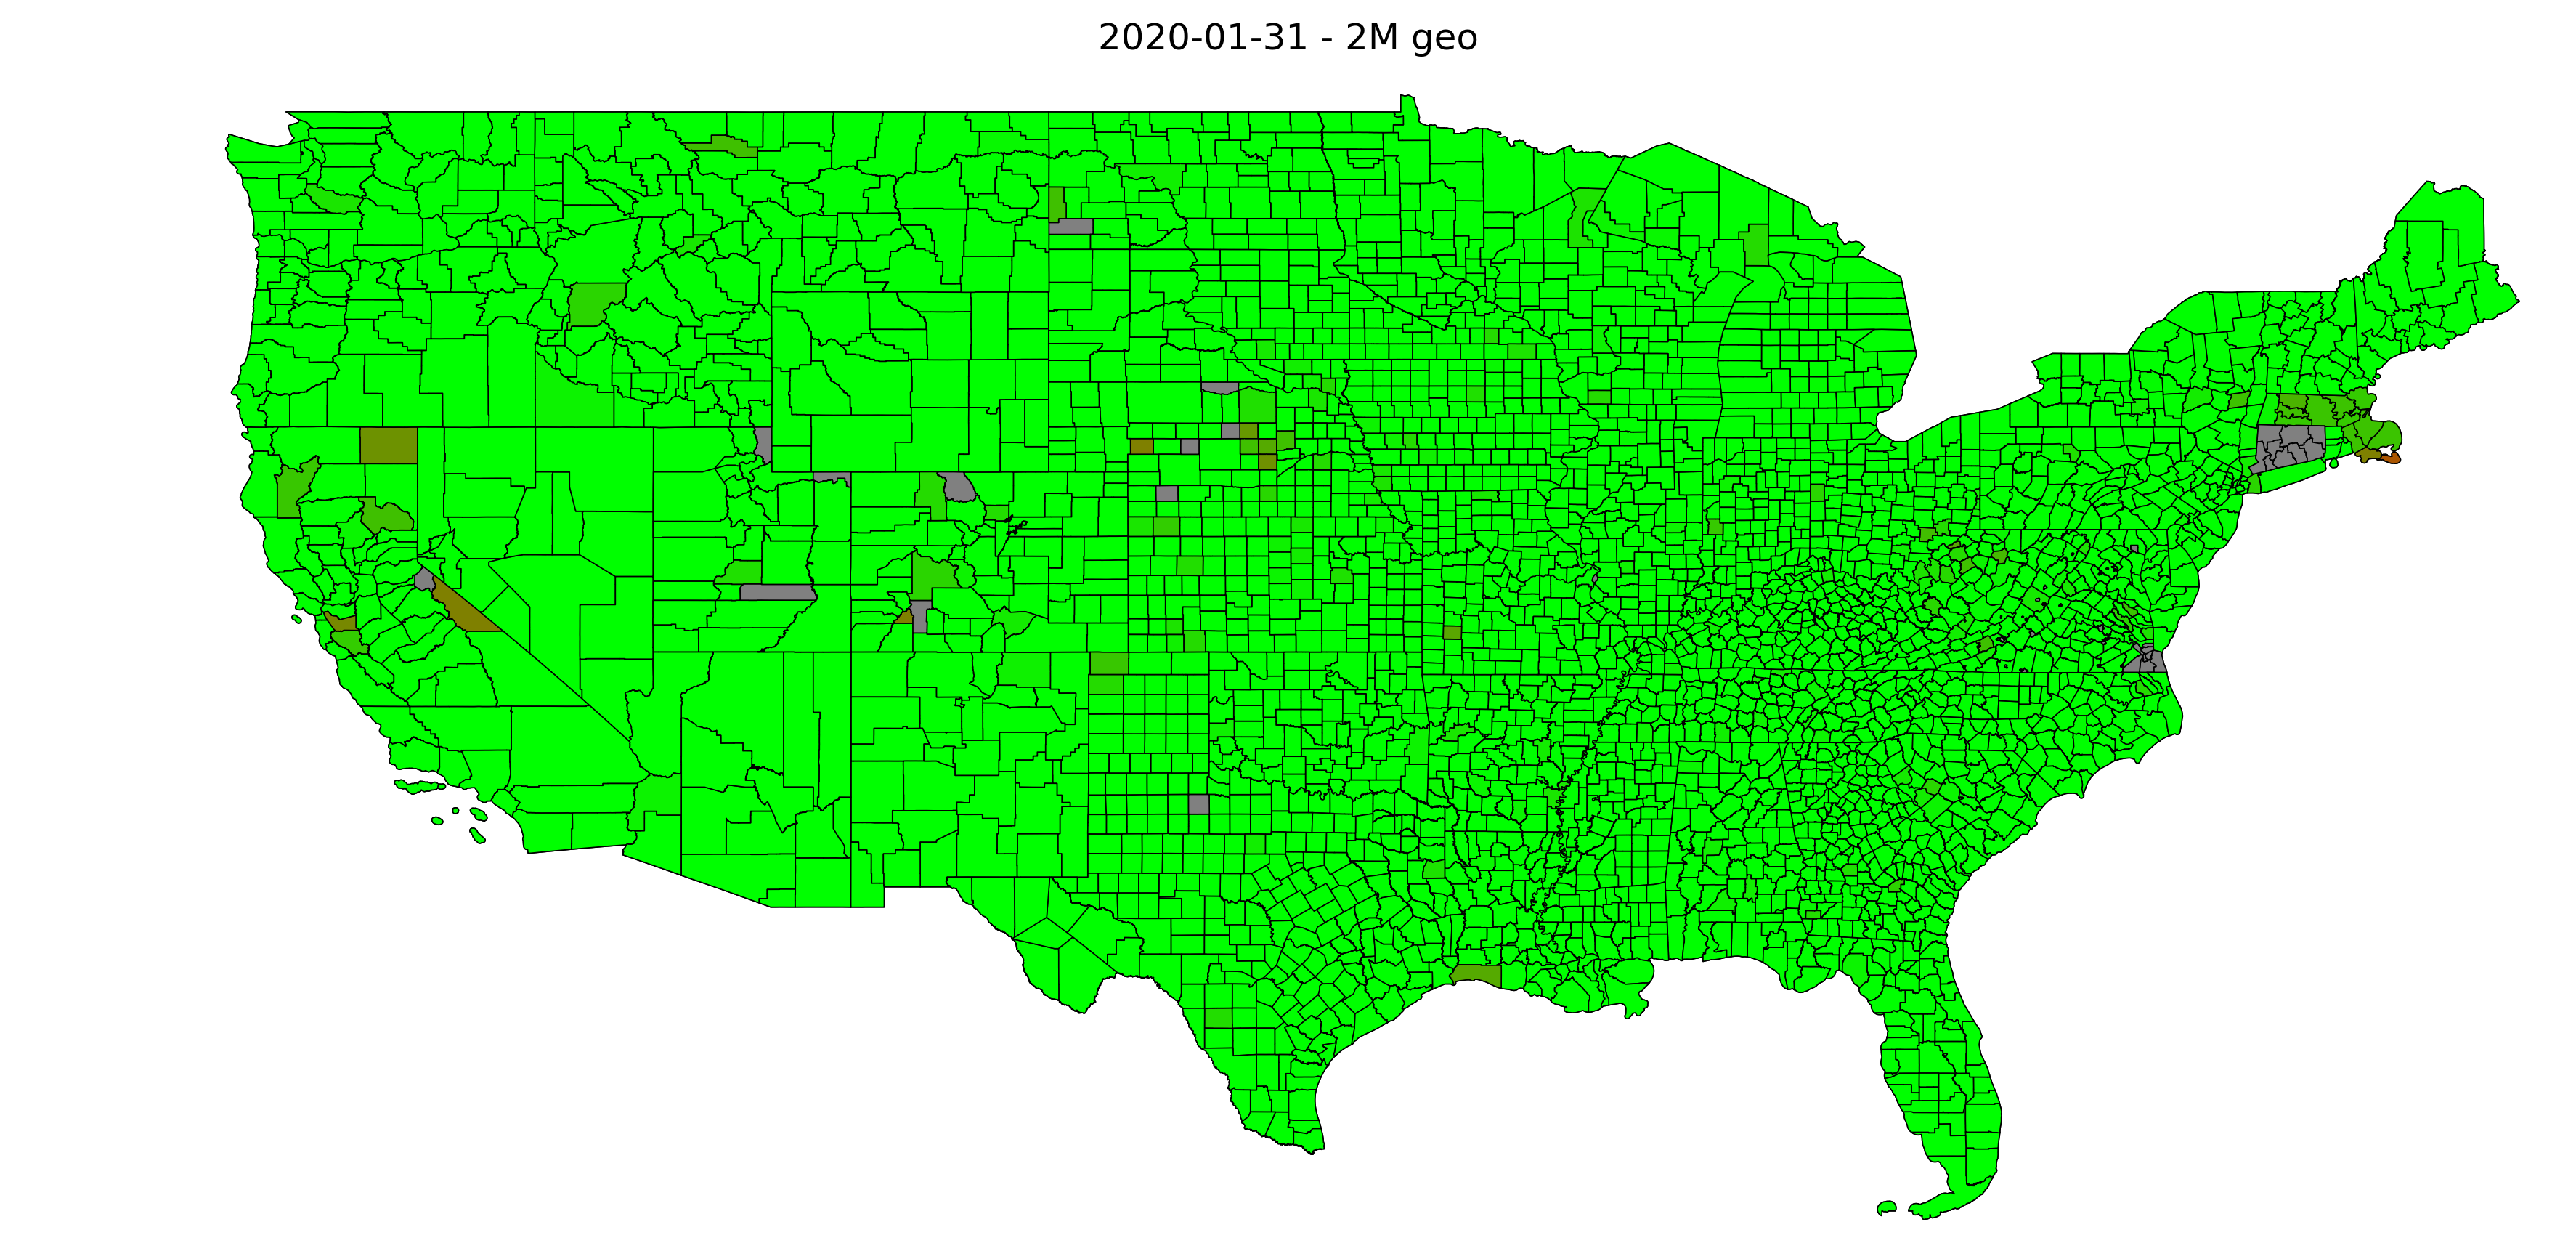

  subregion1_name  subregion2_name state_fips    color
1         Indiana  Hamilton County         18  #00ff00


C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_1312\388494503.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['color'].fillna('#808080', inplace=True)
C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_1312\388494503.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

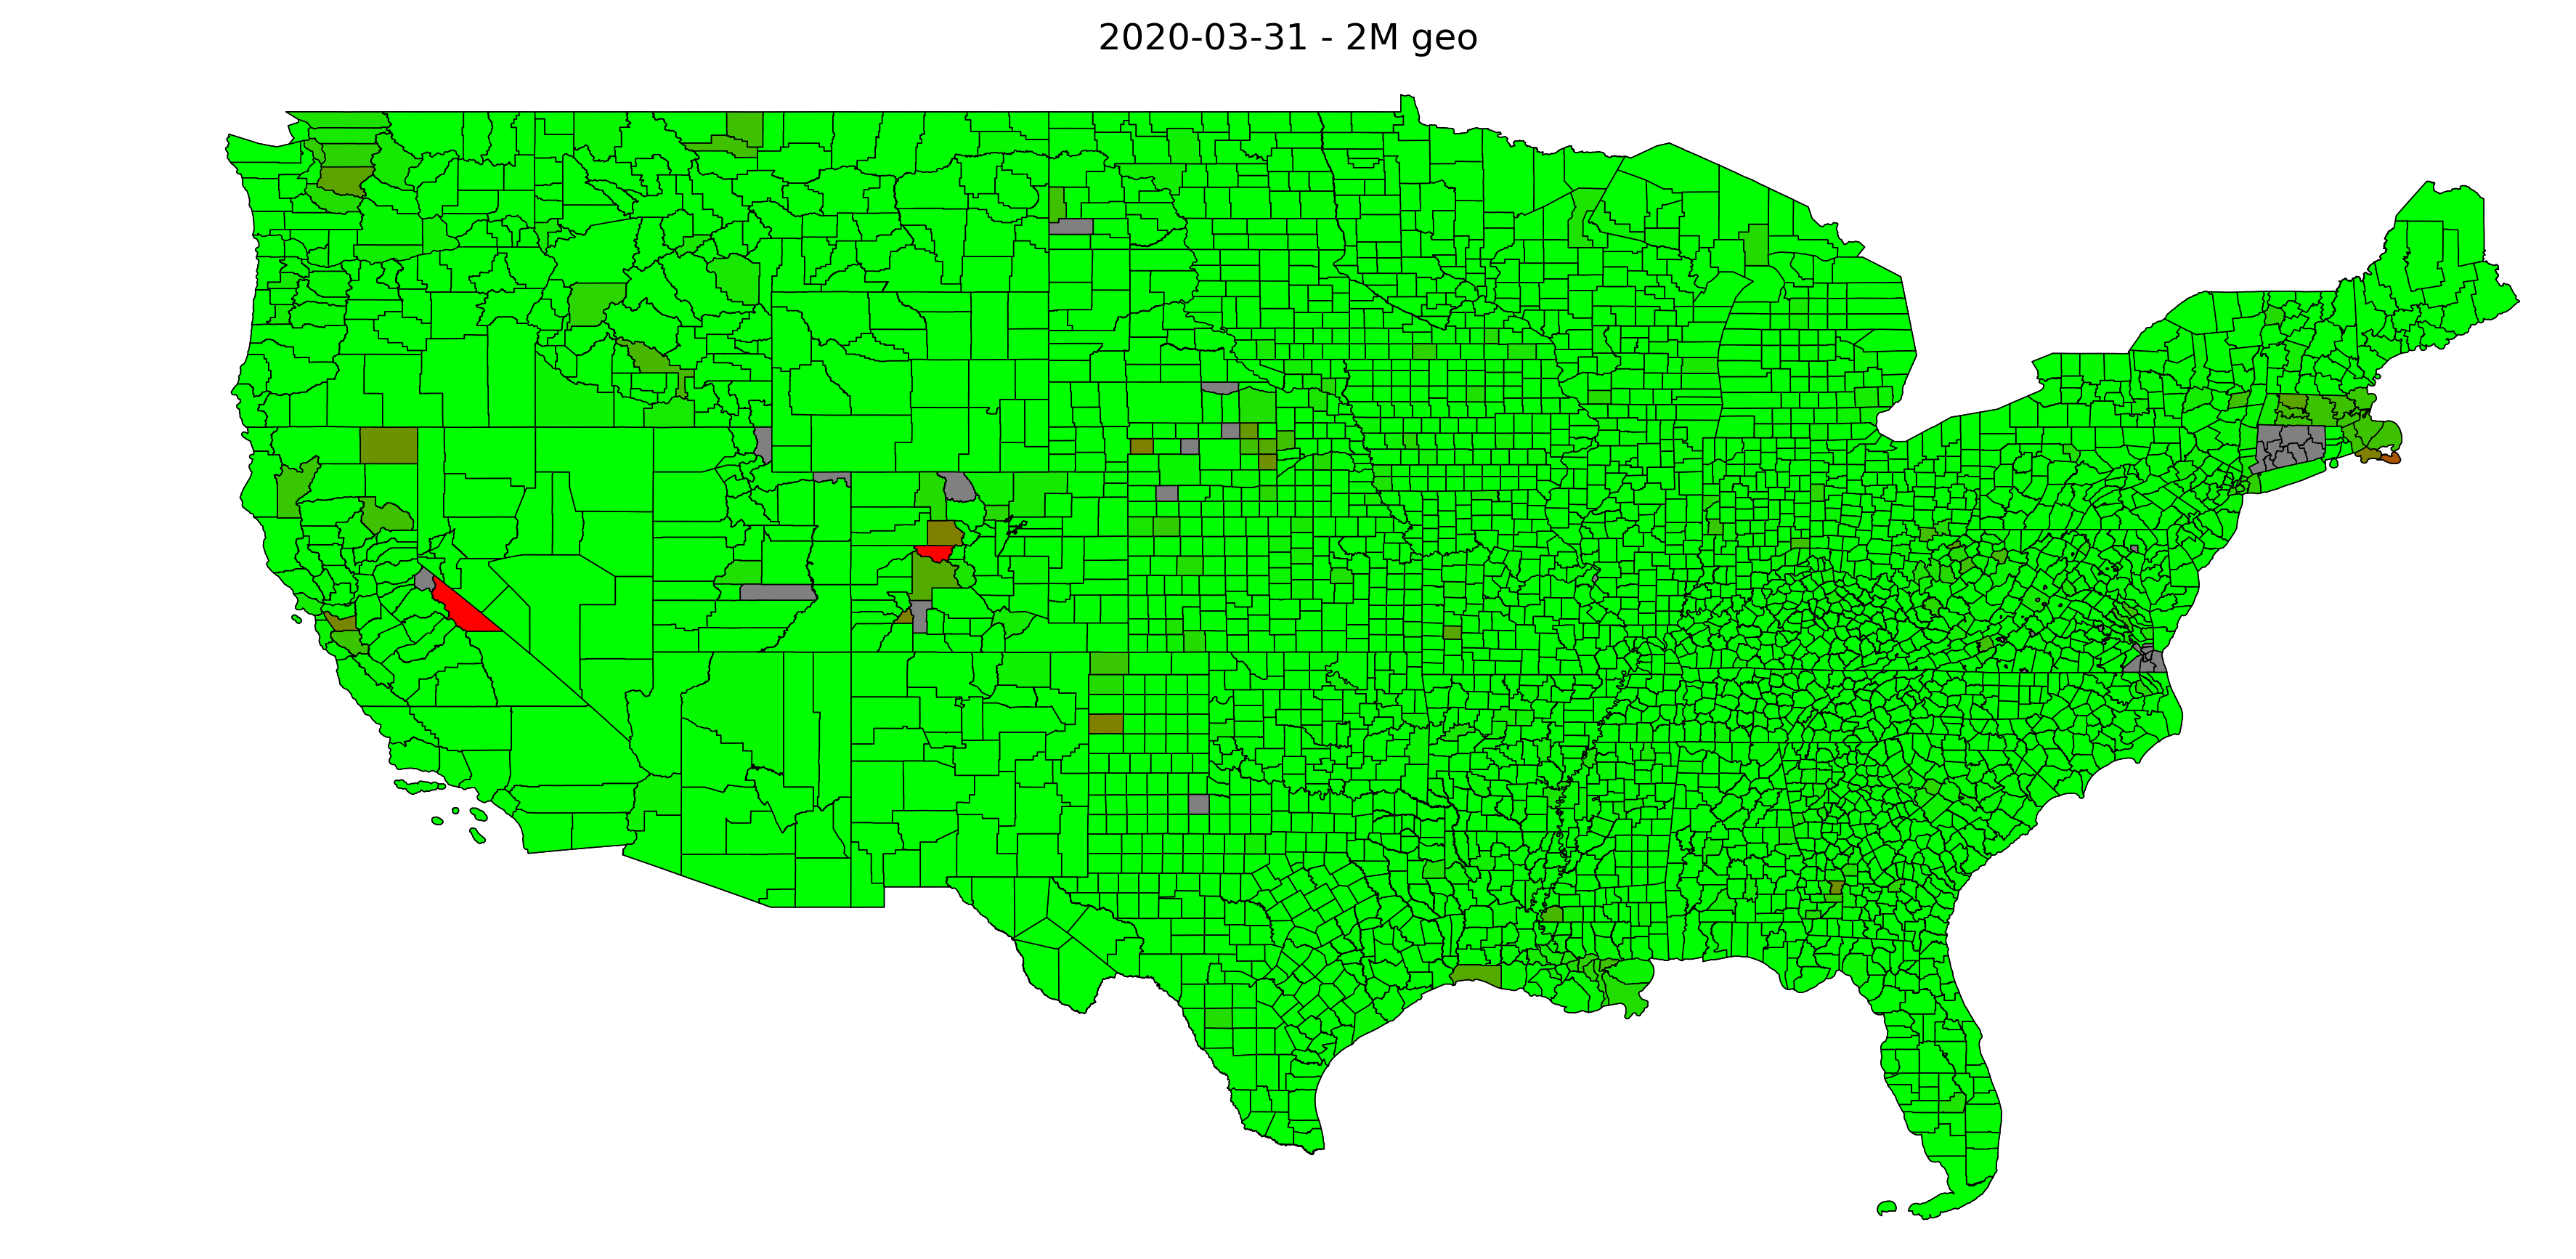

  subregion1_name  subregion2_name state_fips    color
2         Indiana  Hamilton County         18  #a15e00


C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_1312\388494503.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['color'].fillna('#808080', inplace=True)
C:\Users\Collin Coakley\AppData\Local\Temp\ipykernel_1312\388494503.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [14]:
# start running cells here for Gil's stats_[date range].csvs

import pandas as pd
import glob
import os

# Set the directory where the files are located
directory = 'Modified Data'

# Create the full path with the pattern
pattern = os.path.join(directory, 'aggregated_monthly_stats_*.csv')

# Use glob.glob() to find all files matching the pattern
file_list = glob.glob(pattern)

# Iterate through the list of file paths
for file_path in file_list:
    # Extract the filename from the file path
    filename = os.path.basename(file_path)
    
    # Assuming the filename is like 'aggregated_monthly_stats_suffix.csv'
    # Strip the prefix and suffix to get the wildcard part
    wildcard = filename[len('aggregated_monthly_stats_'):-len('.csv')]
    df = pd.read_csv(file_path)
    unique_dates = sorted(df['date'].unique())
    for date in unique_dates:
        filtered_df = filter_csv_by_date_and_columns(file_path, date, columns_to_keep)
        merged_gdf = merge_shapefile_with_data(shape_df, filtered_df, "Modified Data/Shapefiles/Date-{} Interval-{} geo.shp".format(date, wildcard))
        plot_counties_from_merged_gdf(merged_gdf, "{} - {} geo".format(date, wildcard), "Modified Data/{} - {} geo.png".format(date, wildcard))


